# RL, Gymnasium, Q-Learning - Frozen Lake v1

### Hyperparameters:
- (is_slippery=False)
- num_episodes = 7000
- max_steps_per_episode = 100
- learning_rate = 0.1
- discount_rate = 0.9
- exploration_rate = 1
- max_exploration_rate = 1
- min_exploration_rate = 0.01
- exploration_decay_rate = 0.0005
- negative_move_reward = -0.01
- negative_fall_reward = -1

# 1. Setup

In [1]:
# Cell 1: Setup
import gymnasium as gym
import numpy as np
import random
import time
from IPython.display import clear_output

# 2. Environment Setup

> NOTE: Try `is_slippery=True`

Examining the environment with `is_slippery=True`, I see some interesting challenges:

- **Stochastic Transitions:** The slippery ice adds a layer of complexity. Moving in a direction doesn't guarantee staying on course; there's a chance of sliding sideways. This randomness affects state transitions, making them less predictable.

- **Complex Learning:** Because of this slipperiness, our Q-learning algorithm might take longer to converge. The agent not only needs to find the best path to the goal but also learn to adapt to the uncertain movements. It must develop a policy robust enough to handle the variability introduced by the slippery ice.

- **Variance in Rewards:** Expect more variation in rewards during training. With the added uncertainty, the agent will likely experience more falls into holes and lower rewards, especially early on. It's a tougher learning curve, but mastering it means mastering the unpredictability of the environment.

For visualisation purposes, you can change `render_mode='rgb_array'` to `render_mode='human'` and see the environment in action, but this slows down the training process significantly.

In [2]:
# Cell 2: Environment Setup
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
action_space_size = env.action_space.n
state_space_size = env.observation_space.n
q_table = np.zeros((state_space_size, action_space_size))
print("Q-Table Size: ", q_table.shape)

Q-Table Size:  (16, 4)


# 3. Q-Learning Algorithm Implementation

In [15]:
# Cell 3: Q-Learning Algorithm Parameters
num_episodes = 7000
max_steps_per_episode = 100

learning_rate = 0.1  # Increased because the environment is deterministic
discount_rate = 0.9  # Slightly reduced to focus on immediate rewards

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.0005  # Faster decay to shift to exploitation sooner

# Negative rewards
negative_move_reward = -0.01
negative_fall_reward = -1

In [16]:
# Cell 4: Q-Learning Algorithm Implementation with corrected state handling
rewards_all_episodes = []

# Q-learning algorithm
for episode in range(num_episodes):
    initial_state = env.reset()
    state = initial_state[0] if isinstance(initial_state, tuple) else initial_state  # state extraction
    terminated = False
    truncated = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = env.action_space.sample()
        
        # Execute the action
        new_state, reward, terminated, truncated, info = env.step(action)
        new_state = new_state[0] if isinstance(new_state, tuple) else new_state  # state extraction

        # Modify reward for negative rewards
        if reward == 0:
            reward += negative_move_reward
        elif reward == -1:  # Hole
            reward += negative_fall_reward
        
        # Update Q-table for Q(s,a)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        
        state = new_state  # Update the state
        rewards_current_episode += reward
        
        if terminated or truncated:
            break
        
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    
    rewards_all_episodes.append(rewards_current_episode)

    if episode % 100 == 0:  # Print status every 100 episodes to track progress
        print(f"Episode {episode}: Reward = {rewards_current_episode}")

print("Training completed.")

Episode 0: Reward = -0.02
Episode 100: Reward = -0.04
Episode 200: Reward = -0.11999999999999998
Episode 300: Reward = -0.02
Episode 400: Reward = -0.02
Episode 500: Reward = -0.060000000000000005
Episode 600: Reward = -0.03
Episode 700: Reward = -0.11999999999999998
Episode 800: Reward = -0.09999999999999999
Episode 900: Reward = -0.09999999999999999
Episode 1000: Reward = 0.82
Episode 1100: Reward = 0.9
Episode 1200: Reward = -0.04
Episode 1300: Reward = -0.05
Episode 1400: Reward = -0.05
Episode 1500: Reward = -0.08
Episode 1600: Reward = 0.95
Episode 1700: Reward = -0.060000000000000005
Episode 1800: Reward = 0.9299999999999999
Episode 1900: Reward = 0.94
Episode 2000: Reward = 0.94
Episode 2100: Reward = 0.9299999999999999
Episode 2200: Reward = 0.9299999999999999
Episode 2300: Reward = 0.95
Episode 2400: Reward = 0.95
Episode 2500: Reward = 0.89
Episode 2600: Reward = -0.04
Episode 2700: Reward = 0.95
Episode 2800: Reward = -0.04
Episode 2900: Reward = 0.95
Episode 3000: Reward =

# 4. Training Output

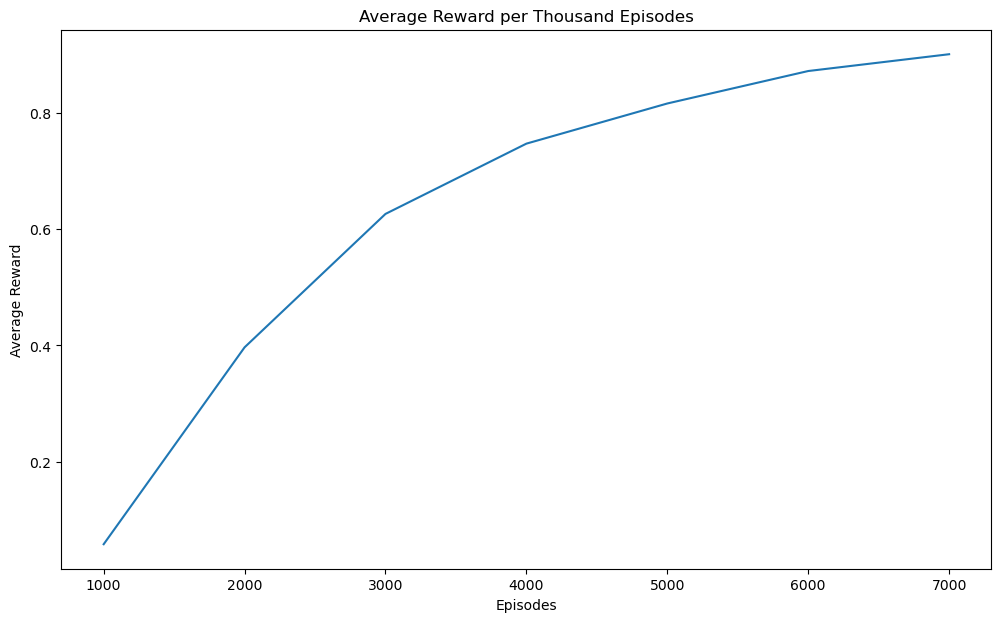

In [17]:
# Cell 5: Visualization of Training Results
import matplotlib.pyplot as plt

# Calculate average reward per thousand episodes
rewards_per_thousand_episodes = np.array(rewards_all_episodes)
num_thousand_episodes = len(rewards_per_thousand_episodes) // 1000

if len(rewards_per_thousand_episodes) % 1000 != 0:
    rewards_per_thousand_episodes = rewards_per_thousand_episodes[:num_thousand_episodes * 1000]

rewards_per_thousand_episodes = rewards_per_thousand_episodes.reshape(-1, 1000)
averages = np.mean(rewards_per_thousand_episodes, axis=1)

# Plotting the average reward per thousand episodes
plt.figure(figsize=(12, 7))
plt.plot(range(1000, num_thousand_episodes * 1000 + 1, 1000), averages)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Thousand Episodes')
plt.show()

# 🔍 Key insights

Examining the Q-learning agent's performance in the deterministic Frozen Lake environment (`is_slippery=false`), here's what I found over 7,000 episodes:

1. **Steady Improvement**: The agent consistently gets better, learning from both good and bad moves.

2. **Negative Rewards Impact**: Penalties for moves and falling into holes push the agent to find quicker paths and avoid hazards better.

3. **Approaching Best Performance**: Performance improves a lot over time, eventually plateauing at a high level, nearing the best possible for this setup.

4. **Possibly Early Peak**: Towards the end of training, the improvement slows, suggesting the agent might have almost reached its best strategy.

### Conclusions

Adding negative rewards helped the agent learn efficiently in this deterministic environment. It learns to move wisely and avoid dangers, leading to high rewards by the end.

Considering the plateau, we might not need all 7,000 episodes. Stopping training once the agent consistently does well could save time and resources.

Overall, negative rewards worked well, encouraging smart moves and careful decision-making, leading to impressive learning in a reasonable time frame.

# 5. Evaluate the Agent

In [18]:
# Cell 6: Evaluate the Agent
for episode in range(3):
    initial_state = env.reset()
    state = initial_state[0] if isinstance(initial_state, tuple) else initial_state  # Extract state index correctly
    terminated = False
    truncated = False
    print("*****Episode ", episode + 1, "*****\n\n\n\n")
    time.sleep(1)
    
    for step in range(max_steps_per_episode):
        clear_output(wait=True)
        env.render()
        time.sleep(0.3)
        
        action = np.argmax(q_table[state,:])
        new_state, reward, terminated, truncated, info = env.step(action)
        new_state = new_state[0] if isinstance(new_state, tuple) else new_state  # Extract state index correctly

        if terminated or truncated:
            clear_output(wait=True)
            env.render()
            if reward == 1:
                print("****You reached the goal!****")
                time.sleep(2)
            else:
                print("****You fell through a hole!****")
                time.sleep(2)
            clear_output(wait=True)
            break
        state = new_state
        
env.close()

****You reached the goal!****
